In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
num_windows = 1000
obvMode = "perfect" # "perfect" or "predicted"

# ==== Prepare DiffusionQ Policy====
diffusionPolicyInterface = DiffusionPolicyInterface(envParams)
model_state_dict = torch.load(f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
diffusionPolicyInterface.diffusionQ.load_state_dict(model_state_dict)
# ==== Evaluate DiffusionQ Policy====
evalResult = diffusionPolicyInterface.eval(env, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")

C:\Users\Ye\AppData\Local\Temp\ipykernel_47784\3726044153.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(f'Results/DiffusionQ/diffusionQ_c

In [4]:
# ==== Prepare MDP Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicy = MdpKernel()
mdpPolicy.load_policy(mdpKernelParams, policyMode="deterministic")
# ==== Evaluate MDP Policy====
policySimulator = PolicySimulator(mdpPolicy, env)
simResultMdp = policySimulator.runSimulation(mdpPolicy, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")

Simulation Progress: 100%|██████████| 1000/1000 [00:01<00:00, 561.17it/s, avg reward=0.003836]


Avg Reward MDP: 0.003835779449347875
Avg Reward DiffusionQ: 0.008337247777849397


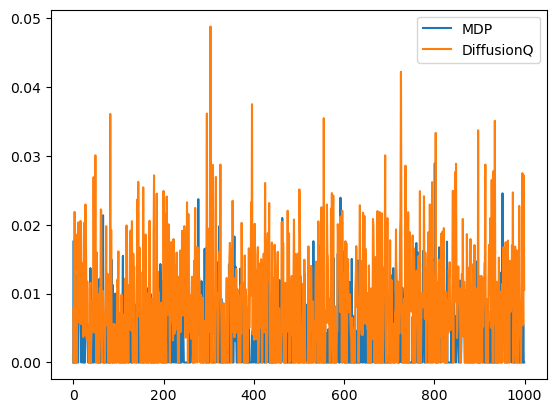

In [5]:
rewardRecord_mdp = simResultMdp['rewardRecord']
rewardRecord_diffusionQ = evalResult['rewardRecord']
print(f"Avg Reward MDP: {np.mean(rewardRecord_mdp)}")
print(f"Avg Reward DiffusionQ: {np.mean(rewardRecord_diffusionQ)}")

plt.plot(rewardRecord_mdp, label='MDP')
plt.plot(rewardRecord_diffusionQ, label='DiffusionQ')
plt.legend()
plt.show()  